# Galaxy Examples - Classification Visualization

This notebook creates publication-quality grids of galaxy examples from the BYOL merger analysis:
- **Layout**: N rows (galaxies) × 3 columns (visualization types)
- **Visualizations**: HSC r-N708-i RGB, HSC i-band (LSB), Starlet HF
- **Galaxy selection**: merger candidates, ambiguous, undisturbed, fragmented examples
- **Automatic cutout fetching**: Pulls missing gri RGB cutouts from cluster if needed

## Configuration
This notebook is config-driven:
- Main config (`../config.yaml`): BYOL data paths, label file
- Figures config (`../configs/figures_config.yaml`): galaxy selection, visualization params

## Setup and Imports

In [1]:
import os
import sys
import pickle
import yaml
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import colors
from astropy.visualization import make_lupton_rgb
from astropy import coordinates

# Add pieridae to path
sys.path.insert(0, str(Path.cwd().parent.parent))

from carpenter import conventions, pixels
from pieridae.starbursts import sample

import make_punchlines

# Import ekfplot if available
try:
    from ekfplot import plot as ek
    EKFPLOT_AVAILABLE = True
    print("✅ ekfplot available")
except ImportError:
    EKFPLOT_AVAILABLE = False
    print("⚠️  ekfplot not available, using standard matplotlib")

print("📦 Imports completed successfully")

✅ ekfplot available
📦 Imports completed successfully


/Users/kadofong/opt/miniconda3/envs/merian/lib/python3.10/site-packages/umap/__init__.py:9: ImportWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn(


## Load Configuration

In [2]:
logger = make_punchlines.setup_logging()

In [3]:
def load_config(config_path: str):
    """Load configuration from YAML file"""
    with open(config_path, 'r') as f:
        config = yaml.safe_load(f)
    return config

# Load main config (BYOL analysis paths)
main_config_path = Path.cwd().parent / 'config.yaml'
main_config = load_config(main_config_path)

# Load figures config (galaxy selection and visualization)
figures_config_path = Path.cwd().parent / 'configs' / 'figures_config.yaml'
figures_config = load_config(figures_config_path)

# Convert paths to Path objects
main_config['data']['input_path'] = Path(main_config['data']['input_path'])
main_config['data']['output_path'] = Path(main_config['data']['output_path'])

print(f"📋 Main config loaded from: {main_config_path}")
print(f"📋 Figures config loaded from: {figures_config_path}")
print(f"📁 BYOL input path: {main_config['data']['input_path']}")
print(f"📁 BYOL output path: {main_config['data']['output_path']}")
print(f"📁 Figure output: {figures_config['figure_output']['output_dir']}")

📋 Main config loaded from: /Users/kadofong/work/projects/merian/pieridae/merger_analysis/config.yaml
📋 Figures config loaded from: /Users/kadofong/work/projects/merian/pieridae/merger_analysis/configs/figures_config.yaml
📁 BYOL input path: ../../local_data/pieridae_output/starlet/msorabove_v0
📁 BYOL output path: ../output/fiducial
📁 Figure output: ../figures/


In [4]:
data_path = Path('../../local_data/pieridae_output/starlet/msorabove_v0/')

def load_image_by_name(img_name: str, data_path: Path) -> np.ndarray:
    """
    Load a single galaxy image on-demand.
    
    Parameters
    ----------
    img_name : str
        Galaxy ID (e.g., 'M1234567890123456789')
    data_path : Path
        Base data directory path
    
    Returns
    -------
    image : np.ndarray
        Image array with shape (3, H, W) containing [g-band, i-band, hf_i-band]
    """
    i_file = data_path / img_name / f"{img_name}_i_results.pkl"
    g_file = data_path / img_name / f"{img_name}_g_results.pkl"
    
    img = []
    for band_file in [g_file, i_file]:
        with open(band_file, 'rb') as f:
            xf = pickle.load(f)
            img.append(xf['image'])
            if band_file == i_file:
                img.append(xf['hf_image'])  # Add HF image for i-band
    
    return np.array(img, dtype=np.float32)

print("✅ Image loading helper function defined")

✅ Image loading helper function defined


In [6]:
data = make_punchlines.load_data(main_config, logger, use_nn_classifier=False)

2025-11-11 09:06:33,409 - make_punchlines - INFO - ============================================================
2025-11-11 09:06:33,410 - make_punchlines - INFO - LOADING DATA
2025-11-11 09:06:33,410 - make_punchlines - INFO - ============================================================
2025-11-11 09:06:33,411 - make_punchlines - INFO - Input path: ../../local_data/pieridae_output/starlet/msorabove_v0
2025-11-11 09:06:33,411 - make_punchlines - INFO - Output path: ../output/fiducial
2025-11-11 09:06:33,411 - make_punchlines - INFO - Loading image names...
2025-11-11 09:06:34,897 - make_punchlines - INFO - Found 22913 images
2025-11-11 09:06:34,897 - make_punchlines - INFO - Loading embeddings...
2025-11-11 09:06:34,923 - make_punchlines - INFO - Embeddings shape: (22913, 512)
2025-11-11 09:06:34,924 - make_punchlines - INFO - Computing PCA...
2025-11-11 09:06:34,925 - INFO - Computing PCA...
2025-11-11 09:06:35,156 - INFO - PCA components: 20
2025-11-11 09:06:35,157 - INFO - Explained 

Computed aperture correction in 0.0 seconds.
Computed line contamination correction in 0.0 seconds.
Loading precomputed Galactic extinction map...
Interpolated Galactic extinction values from map.
Computed Galactic extinction correction in 0.5 seconds.
Computed internal extinction corrections in 0.6 seconds.


/Users/kadofong/work/projects/merian/agrias/python/agrias/photometry.py:115: RuntimeWarning: invalid value encountered in log10
  lsq_y = np.log10(np.array([ fdict[band] for band in plawbands ]))
/Users/kadofong/opt/miniconda3/envs/merian/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/kadofong/opt/miniconda3/envs/merian/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
2025-11-11 09:06:39,194 - make_punchlines - INFO - Loading adjusted masses from individual files...
Loading masses:   0%|                                                           | 0/54859 [00:00<?, ?it/s]/Users/kadofong/work/projects/merian/pieridae/merger_analysis/figure_generation/make_punchlines.py:309: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

In [7]:
catalog = data['catalog']
img_names = data['img_names']

labels = data['labels']
label_meanings = main_config['labels']['label_mapping']
prob_labels_iter = data['prob_labels_iter']
n_labels_iter = data['n_labels_iter']

print("📊 Label distribution:")
unique, counts = np.unique(labels, return_counts=True)
for label_val, count in zip(unique, counts):
    meaning = label_meanings.get(label_val, f"unknown_{label_val}")
    print(f"   {label_val} ({meaning}): {count} objects")

📊 Label distribution:
   0 (unclassified): 19960 objects
   1 (undisturbed): 2314 objects
   2 (ambiguous): 214 objects
   3 (merger): 96 objects
   4 (fragmentation): 280 objects
   5 (artifact): 49 objects


## Select Example Galaxies

Choose which mass regime to visualize: `lowmass` or `highmass`

In [111]:
# Choose mass regime
MASS_REGIME = 'lowmass'  # Change to 'highmass' as needed

# Get selection parameters from config
mode = figures_config['galaxy_selection']['mode']
mass_threshold = figures_config['galaxy_selection']['mass_threshold']



print(f"🎯 Selecting galaxies for: {MASS_REGIME}")
print(f"   Mass threshold: log(M*/Msun) < {mass_threshold}")

preselect = False


# Use preselected galaxies from config/notebook
if preselect:
    if MASS_REGIME == 'highmass':
        all_selected = [9142, 8831, 7258, 3876]
        all_selected = [9142, 3691, 7509, 7258,]# 3876]
        #galaxy_labels = ['Likely merger', 'Likely ambiguous', 'Likely undisturbed', 'Likely fragmented']
    elif MASS_REGIME == 'lowmass':
        all_selected = [10607, 20519, 19747, 6898]
        #all_selected = [10607, 19747, 6898]
        #np.random.seed(10)#random_seed)
else:
    if MASS_REGIME == 'lowmass':
        codes = [1,2,2,3]
        random_seed = 331
    elif MASS_REGIME == 'highmass':
        codes = [1,2,3,3]
        random_seed = 135
    np.random.seed(random_seed)
    all_selected = []
    for ix in codes:
        if ix == 4:
            is_cand = (prob_labels_iter[:,ix] > 0.1)
        else:
            is_cand = (prob_labels_iter[:,ix] > 0.5)
        if (ix > 1)&(ix<4):
            is_cand = (prob_labels_iter[:,2]+prob_labels_iter[:,3]) > (MASS_REGIME == 'highmass' and 0.5 or 0.4)
            if ix == 2:
                is_cand &= prob_labels_iter[:,2] > prob_labels_iter[:,3]
            else:
                is_cand &= prob_labels_iter[:,2] < prob_labels_iter[:,3]
        #else:
        #    is_cand = (prob_labels_iter[:,ix] > 0.5)
        #if ix != 4:
        #    is_cand &= (prob_labels_iter[:,4]<main_config['labels']['frag_threshold'])

        if MASS_REGIME == 'highmass':
            drawmask = (catalog.reindex(img_names)['logmass_adjusted']>9.)&is_cand
        elif MASS_REGIME == 'lowmass':
            drawmask = (catalog.reindex(img_names)['logmass_adjusted']<9.)&is_cand

        print(ix, drawmask.sum())
        all_selected.append(np.random.choice(np.arange(len(img_names),dtype=int)[drawmask], 1)[0])
        
    galaxy_labels = ['Likely merger', 'Likely undisturbed', 'Likely fragmented']

if preselect:
    print(f"✅ Using preselected galaxies: {all_selected}")

# Get selected names
selected_names = img_names[all_selected]
print(f"   Galaxy IDs: {' '.join(selected_names)}")

🎯 Selecting galaxies for: lowmass
   Mass threshold: log(M*/Msun) < 9.0
1 15133
2 10
2 10
3 2
   Galaxy IDs: M3322055636069416045 M3493465100793169258 M3581703107945458272 M3406458546664009440


In [112]:
# Check cutout availability and pull if needed
cutout_base = Path('./figure_data/')
print(f"📂 Checking cutouts in: {cutout_base}")

# Ensure output directories exist
cutout_base.mkdir(parents=True, exist_ok=True)
(cutout_base / 'merian').mkdir(parents=True, exist_ok=True)
(cutout_base / 'hsc').mkdir(parents=True, exist_ok=True)

missing_cutouts = []

for targetid, gid in zip(selected_names, all_selected):
    objname = conventions.produce_merianobjectname(*catalog.loc[targetid, ['RA', 'DEC']].values)
    
    # Check if all required cutouts exist
    cutouts_exist = True
    for band in ['r', 'N708', 'i']:
        if band in ['N708', 'N540']:
            cutout = cutout_base / 'merian' / f'{objname}_{band}_merim.fits'
        else:
            cutout = cutout_base / 'hsc' / f'{objname}_HSC-{band}.fits'
        
        if not cutout.exists():
            cutouts_exist = False
            break
    
    if not cutouts_exist:
        missing_cutouts.append(targetid)
        print(f"⚠️  Missing cutouts for {targetid} ({objname})")


📂 Checking cutouts in: figure_data
⚠️  Missing cutouts for M3322055636069416045 (J094551.64-010519.33)
⚠️  Missing cutouts for M3581703107945458272 (J095618.67+030835.28)
⚠️  Missing cutouts for M3406458546664009440 (J090820.30+001143.90)


## Load Cutouts for Selected Galaxies

In [113]:
# Load cutout data
print(f"📂 Loading cutouts from: {cutout_base}")

bbmb_d = {}

for targetid, gid in zip(selected_names, all_selected):
    objname = conventions.produce_merianobjectname(*catalog.loc[targetid, ['RA', 'DEC']].values)
    bbmb = pixels.BBMBImage()

    success = True
    for band in ['r', 'N708', 'i']:
        if band in ['N708', 'N540']:
            cutout = cutout_base / 'merian' / f'{objname}_{band}_merim.fits'
        else:
            cutout = cutout_base / 'hsc' / f'{objname}_HSC-{band}.fits'
        
        if not cutout.exists(): 
            bbmb = None
            print(f'⚠️  Skipping {targetid}, cutout not found: {cutout}')
            print(f'    Will use fallback (i-band grayscale) instead')
            success = False
            break
            
        psf = None
        bbmb.add_band(
            band,
            coordinates.SkyCoord(catalog.loc[targetid, 'RA'], catalog.loc[targetid, 'DEC'], unit='deg'),
            size=150,
            image=str(cutout),
            var=str(cutout),
            image_ext=1,
            var_ext=3,
        )
    
    if success:
        bbmb_d[gid] = bbmb
    else:
        bbmb_d[gid] = None

print(f"✅ Loaded cutouts for {sum(1 for v in bbmb_d.values() if v is not None)}/{len(all_selected)} galaxies")
if any(v is None for v in bbmb_d.values()):
    print("   Note: Some galaxies will use i-band fallback images")

📂 Loading cutouts from: figure_data
⚠️  Skipping M3322055636069416045, cutout not found: figure_data/hsc/J094551.64-010519.33_HSC-r.fits
    Will use fallback (i-band grayscale) instead
⚠️  Skipping M3581703107945458272, cutout not found: figure_data/hsc/J095618.67+030835.28_HSC-r.fits
    Will use fallback (i-band grayscale) instead
⚠️  Skipping M3406458546664009440, cutout not found: figure_data/hsc/J090820.30+001143.90_HSC-r.fits
    Will use fallback (i-band grayscale) instead
✅ Loaded cutouts for 1/4 galaxies
   Note: Some galaxies will use i-band fallback images


## Create Galaxy Examples Grid

🎨 Creating 3×4 visualization grid (rows=viz types, cols=galaxies)
Ignoring q, using qlow
Ignoring q, using qhigh
Ignoring q, using qlow
Ignoring q, using qhigh
Ignoring q, using qlow
Ignoring q, using qhigh
Ignoring q, using qlow
Ignoring q, using qhigh


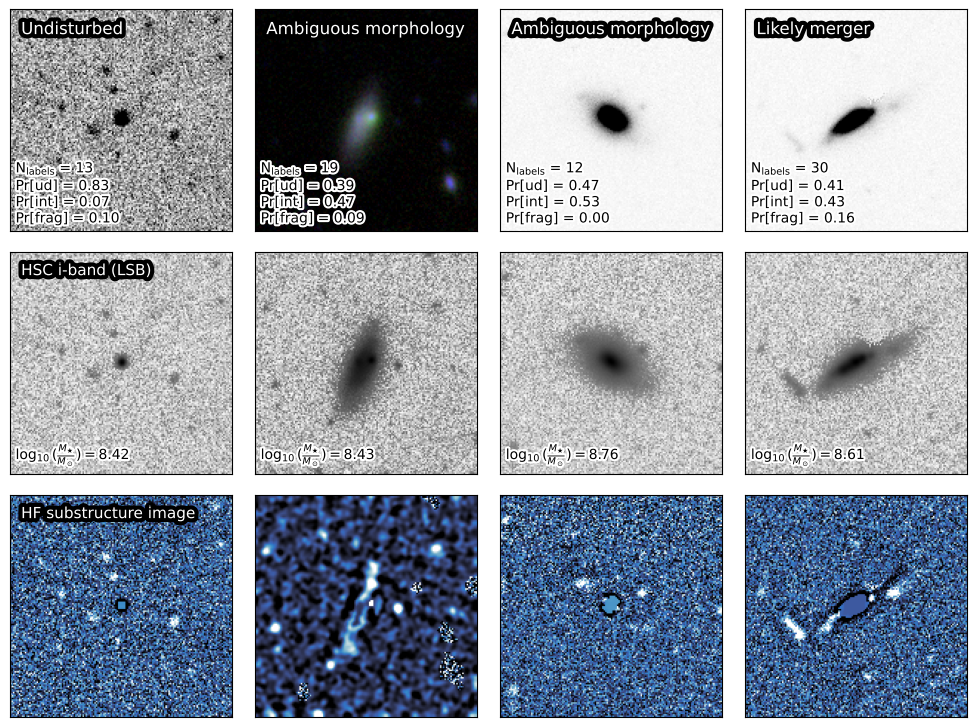

In [114]:
import cmasher
cmap = cmasher.arctic

# Get visualization parameters from config
from ekfplot import colors as ec, colorlists

viz_config = figures_config['visualization']
fig_config = figures_config['figure_output']

n_galaxies = len(all_selected)
n_viz_types = 3

# Figure dimensions - TRANSPOSED: rows are viz types, columns are galaxies
fig_width = fig_config['figsize']['width'] / 3. * n_galaxies
fig_height = fig_config['figsize']['height_per_galaxy'] * n_viz_types

print(f"🎨 Creating {n_viz_types}×{n_galaxies} visualization grid (rows=viz types, cols=galaxies)")

# Create figure with TRANSPOSED dimensions
fig, axarr = plt.subplots(n_viz_types, n_galaxies, figsize=(fig_width, fig_height))

# Handle case where we only have one visualization type (axarr would be 1D)
if n_viz_types == 1:
    axarr = axarr.reshape(1, -1)
# Handle case where we only have one galaxy (axarr would be 1D)
if n_galaxies == 1:
    axarr = axarr.reshape(-1, 1)

for col_idx, gix in enumerate(all_selected):
    # Row 0: r-N708-i RGB image
    bbmb = bbmb_d[gix]
    current_img = load_image_by_name(img_names[gix], data_path)
    if bbmb is None:
        # Fallback: use i-band grayscale
        
        if EKFPLOT_AVAILABLE:            
            ek.imshow(
                current_img[1],
                origin='lower',
                cmap='Greys',
                q=0.01,
                ax=axarr[0, col_idx]
            )
        else:
            axarr[0, col_idx].imshow(
                current_img[1],
                origin='lower',
                cmap='Greys',
                norm=colors.AsinhNorm()
            )
    else:
        rgb = make_lupton_rgb(
            bbmb.image['r'], 
            bbmb.image['N708'], 
            bbmb.image['i'], 
            Q=viz_config['lupton']['Q'], 
            stretch=viz_config['lupton']['stretch']
        )
        if EKFPLOT_AVAILABLE:
            ek.imshow(rgb, ax=axarr[0, col_idx])
        else:
            axarr[0, col_idx].imshow(rgb)
            axarr[0, col_idx].set_aspect('equal')
    
    # Row 1: HSC i-band (LSB with SymLog normalization)
    axarr[1, col_idx].imshow(
        current_img[1],
        origin='lower',
        cmap=viz_config['lsb']['colormap'],
        norm=colors.SymLogNorm(linthresh=viz_config['lsb']['linthresh'])
    )
    
    # Row 2: Starlet HF
    ek.imshow(
        current_img[2],
        ax=axarr[2, col_idx],
        cmap=cmap,
        qlow=0.05,
        qhigh=0.99,
    )

    # Add probability labels to first row (RGB images)
    label_config = viz_config['labels']
    label_text = rf'''N$_{{{{\rm labels}}}}$ = {n_labels_iter[gix]}
Pr[ud] = {prob_labels_iter[gix, 1]:.2f}
Pr[int] = {prob_labels_iter[gix, 3] + prob_labels_iter[gix, 2]:.2f}
Pr[frag] = {prob_labels_iter[gix, 4]:.2f}'''
    
    if EKFPLOT_AVAILABLE:
        ek.text(
            0.025,
            0.025,
            label_text,
            ax=axarr[0, col_idx],
            fontsize=label_config['fontsize'],
            bordercolor=label_config['bordercolor'],
            color=label_config['textcolor'],
            borderwidth=label_config['borderwidth']
        )
    else:
        axarr[0, col_idx].text(
            0.025, 0.025, label_text,
            transform=axarr[0, col_idx].transAxes,
            fontsize=label_config['fontsize'],
            color=label_config['textcolor'],
            verticalalignment='bottom',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
        )

    # Add stellar mass to second row (i-band images)
    with open(f"{main_config['data']['input_path']}/{img_names[gix]}/{img_names[gix]}_i_results.pkl", 'rb') as f:
        x = pickle.load(f)
        logmstar = x['logmass_adjusted']

    mass_text = rf'''$\log_{{{{10}}}}(\frac{{{{M_{{{{\bigstar}}}}}}}}{{{{M_\odot}}}})={logmstar:.2f}$'''
    ek.text(
        0.025,
        0.025,
        mass_text,
        ax=axarr[1, col_idx],
        fontsize=label_config['fontsize'],
        bordercolor=label_config['bordercolor'],
        color=label_config['textcolor'],
        borderwidth=label_config['borderwidth']
    )


# Add column headers (galaxy labels) to top row
row_labels = viz_config['row_labels']
if MASS_REGIME == 'highmass':
    label_order = ['merger', 'merger', 'ambiguous', 'undisturbed']
else:
    label_order = ['merger','ambiguous','undisturbed','fragmented']
label_order = [ label_meanings[x] for x in codes ]
    
for col_idx, label_key in enumerate(label_order[:n_galaxies]):
    if label_key in row_labels:
        ek.text(
            0.05, 
            0.95, 
            row_labels[label_key], 
            ax=axarr[0, col_idx], 
            fontsize=label_config['fontsize_title'], 
            bordercolor='k', 
            color='w', 
            borderwidth=6
        )


# Add row labels (visualization types) to first column
headers = viz_config['headers']
if headers['col1']:
    ek.text(
        0.05, 0.95, 
        headers['col1'], 
        ax=axarr[1, 0], 
        fontsize=label_config['fontsize_header'], 
        bordercolor='k', 
        color='w', 
        borderwidth=6
    )


if headers['col2']:
    ek.text(
        0.05, 0.95, 
        headers['col2'], 
        ax=axarr[2, 0], 
        fontsize=label_config['fontsize_header'], 
        bordercolor='k', 
        color='w', 
        borderwidth=6
    )


# Remove ticks from all axes
for ax in axarr.flatten():
    ax.set_xticks([])
    ax.set_yticks([])

# Adjust spacing
plt.tight_layout()
plt.subplots_adjust(wspace=fig_config['wspace'], hspace=fig_config['hspace'])

plt.tight_layout ()

## Save Figure

In [400]:
# Save figure
output_dir = Path('./punchline_figures/')
output_dir.mkdir(parents=True, exist_ok=True)
                 
filename = fig_config['filename_pattern'].format(mode=MASS_REGIME)
output_path = output_dir / filename

fig.savefig(output_path, dpi=fig_config['dpi'], bbox_inches='tight')


✅ Figure saved to: punchline_figures/galaxy_examples_highmass.pdf
